# Marker Gene Analysis of Identified Cell Clusters
According to this [Manual](https://www.sc-best-practices.org/cellular_structure/annotation.html)
- Developed by: Christian Eger
- Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
- Created on: 240813
- Last modified: 240913<br>

## Importing Modules

In [1]:
import scanpy as sc
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## Helper Functions

In [2]:

def plt_counts_hist(
        adata: AnnData,
        layer: str=None,
        **kwargs
):
    if layer:
        counts = adata.layers[layer]
    else:
        counts = adata.X
    sns.histplot(
        counts.sum(1),
        **kwargs
    )

def plt_counts_hist_layers(
        adata: AnnData
):
    titles = ['X'] + list(adata.layers.keys())
    n_plots = len(titles)
    fig, axes = plt.subplots(ncols=n_plots, figsize=(6 * n_plots, 4))

    plt.sca(axes[0])  
    plt_counts_hist(adata)
    axes[0].set_title("X")
    for idx, layer in enumerate(adata.layers.keys(), start=1):
        plt.sca(axes[idx])  
        plt_counts_hist(adata, layer=layer)
        axes[idx].set_title(f"Layer: {layer}")
    plt.tight_layout()
    plt.show()

## Data Prep

### Data Loading

In [3]:
adata_path = Path('../.data/Marburg_cell_states_locked_ctl240709.raw.h5ad')
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

### Normalize and Log Transform

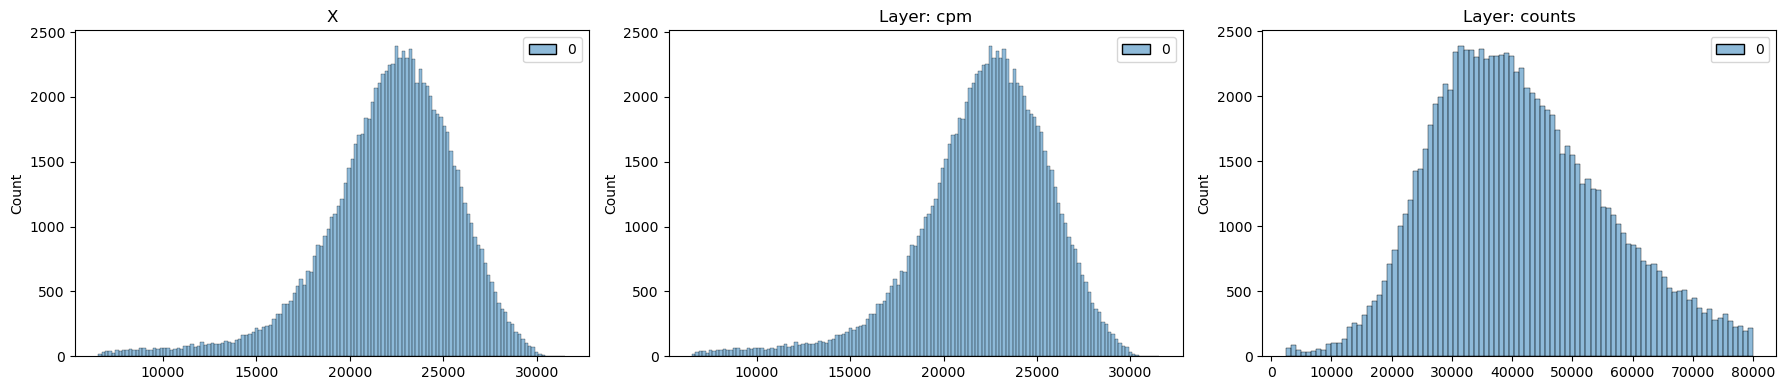

In [4]:
'''
Storing a counts per million layer in the adata Object and log transforming it
target_sum=1e6; for CPM Normalization
exclude_highly_expressed=True; As to not strongly shift the normalization of non highly expressed genes
'''
adata.layers['cpm'] = sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True,
    inplace=False
)['X']

sc.pp.log1p(
    adata,
    layer='cpm'
)

'''
Swapping Raw Counts with log1p transformed cpm normalized data
'''
adata.layers['counts'] = adata.X
adata.X = adata.layers['cpm']

plt_counts_hist_layers(adata)

### Rank genes groups

In [5]:
'''
method='wilcoxon'; According to this recommendation https://www.biorxiv.org/content/10.1101/2022.05.09.490241v1
corr_method='benjamini-hochberg'; default correction for rank_genes_groups
'''
sc.tl.rank_genes_groups(
    adata, 
    groupby="cell_compartment", 
    method="wilcoxon", 
    corr_method='benjamini-hochberg',
    key_added="dea_leiden_2"
)

## Plots

/home/ceger/miniforge3/envs/scanpy-env/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 27208 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


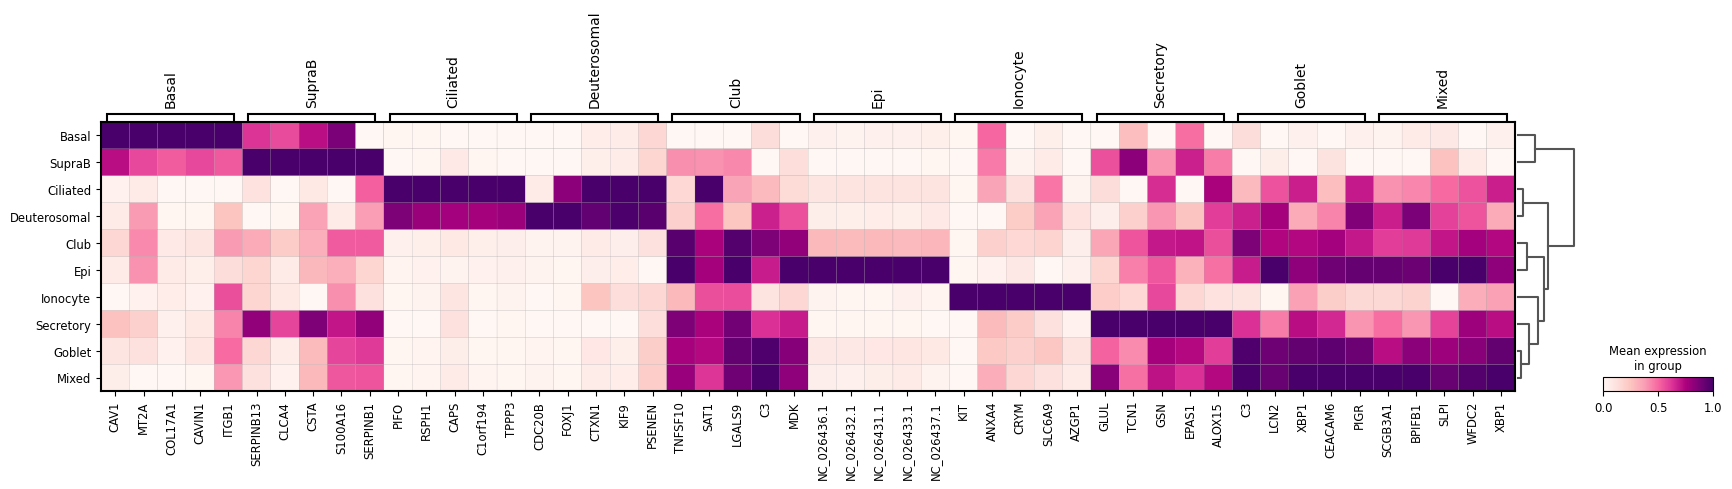

In [6]:
sc.pl.rank_genes_groups_matrixplot(
    adata, 
    groupby="cell_compartment", 
    standard_scale="var", 
    n_genes=5, 
    key="dea_leiden_2",
    cmap='RdPu'
)

In [7]:
'''
min_in_group_fraction=0.2, Filtering genes for ingroup expression of maximal 20%
max_out_group_fraction=0.2, Filtering genes for outgroup expression of maximal 20%
'''
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_2",
    key_added="dea_leiden_2_filtered",
)

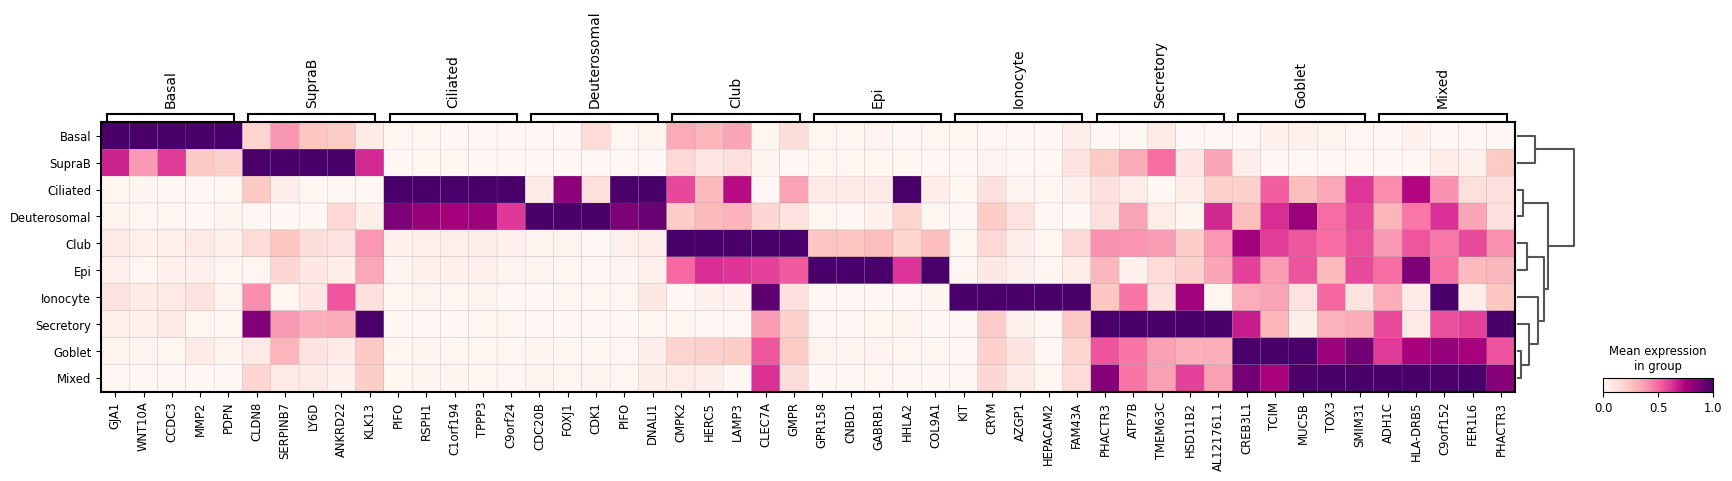

In [8]:
sc.pl.rank_genes_groups_matrixplot(
    adata, 
    groupby="cell_compartment", 
    standard_scale="var", 
    n_genes=5, # Selecting Top 5 Genes
    key="dea_leiden_2_filtered",
    cmap='RdPu'
)

categories: APOD+Ciliated, CCDC3+Basal1, DHRS9+Club, etc.
var_group_labels: Basal, Ciliated, Club, etc.


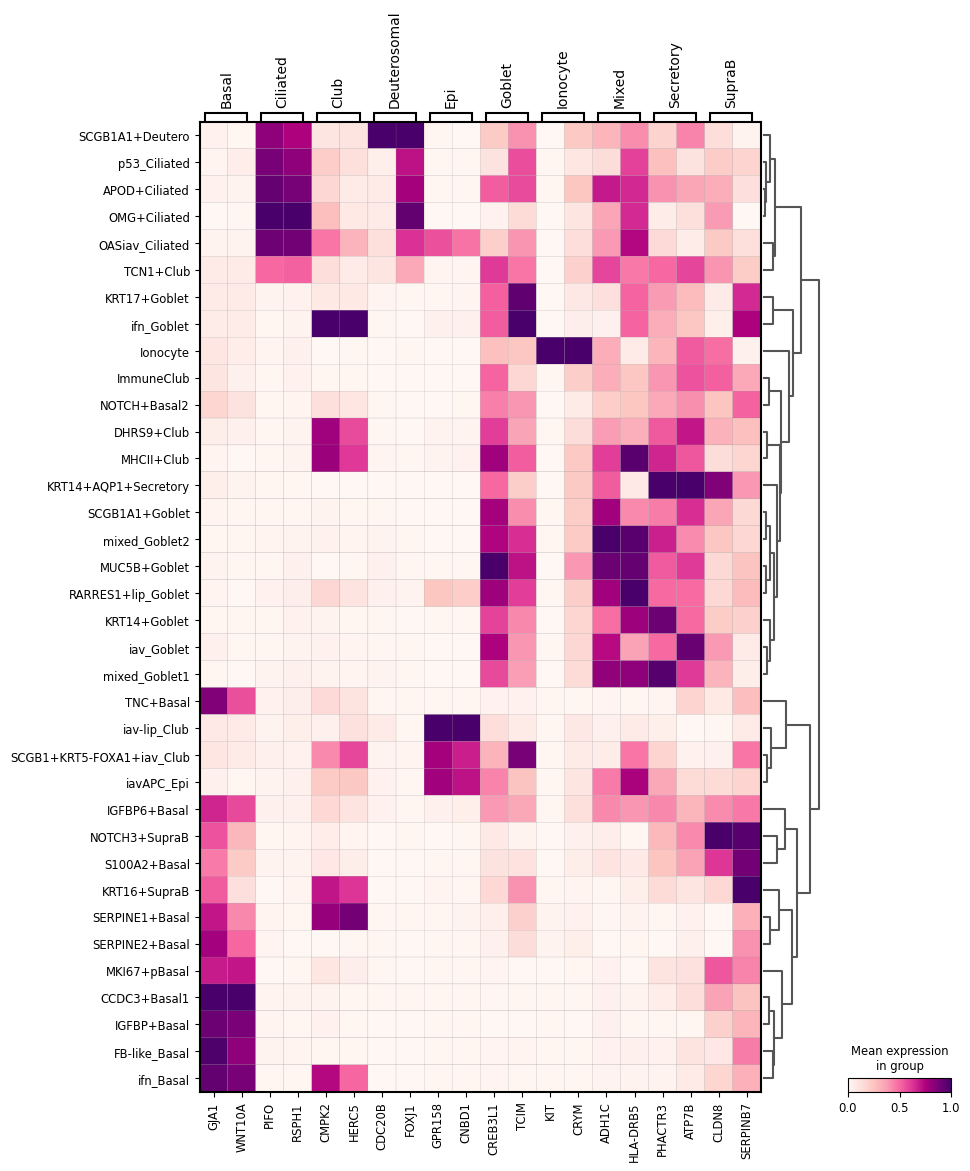

In [9]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    groupby="cell_states",
    standard_scale="var",
    n_genes=2,
    key="dea_leiden_2_filtered",
    cmap='RdPu'
)